# チュートリアル

こちらのノートブックでは、セットアップしたデータに対して基本的な操作をおこなうためのチュートリアルが含まれています。

## ライブラリのインポート

必要なライブラリをインポートします。

In [1]:
import numpy as np # https://numpy.org/ja/
import pandas as pd # https://pandas.pydata.org/
import matplotlib.pyplot as plt
%matplotlib inline 

## データの読み込み

pickleファイルをデータフレームに読み込みます。

In [2]:
df=pd.read_pickle("../input/LSWMD_25519.pkl")

## データの確認

データフレームのメソッドを用いてデータのメタ情報を確認します。

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25519 entries, 0 to 25518
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   waferMap     25519 non-null  object 
 1   dieSize      25519 non-null  float64
 2   lotName      25519 non-null  object 
 3   waferIndex   25519 non-null  float64
 4   failureType  25519 non-null  object 
dtypes: float64(2), object(3)
memory usage: 997.0+ KB
None


格納されているデータの中身を三つほど確認します。

,waferMap,dieSize,lotName,waferIndex,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,20.0,Loc
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,12.0,Edge-Loc
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,13.0,Edge-Loc


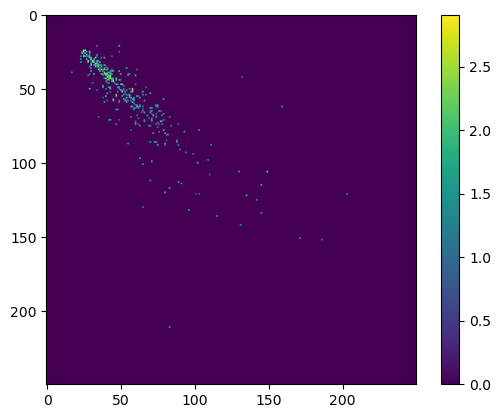

max_x_vale 212
max_y_vale 204


In [4]:
display(df.head(3))

from PIL import Image

def show_img(image):
    import matplotlib.pyplot as plt
    import numpy as np
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

wafer_maps = df['waferMap']
(max_x_vale,max_y_vale) = wafer_maps[0].shape;
for map in wafer_maps:
    (x,y) = map.shape
    if x > max_x_vale:
        max_x_vale = x
    if y > max_y_vale:
        max_y_vale = y
max_value = 0
if max_x_vale > max_y_vale:
   max_value = max_x_vale
else :
    max_value =max_y_vale
size_map = np.zeros(shape=(250,250),dtype=np.int32)
for map in wafer_maps:
    (x,y) = map.shape
    size_map[x-1, y-1] += 1
size_map = size_map * 2
size_map = size_map + 1
size_map = np.log(size_map)
size_map = size_map * 2
size_map = size_map + 1
size_map = np.log(size_map)
plt.figure()
plt.imshow(size_map)
plt.colorbar()
plt.grid(False)
plt.show()
print('max_x_vale',max_x_vale)
print('max_y_vale',max_y_vale)


各カテゴリーごとのwaferMapの中身を表示します。

In [5]:
def serch_area(map, y_start, x_start):
    stack = [(y_start, x_start),]
    (map_y,map_x) = map.shape   
    area_set = []
    while len(stack) > 0:
        y, x = stack.pop()
        area_set.append((y, x))
        map[y,x] = 1
        if y > 0 and map[y - 1, x] == 2:
            stack.append((y - 1, x))
        if x > 0 and map[y, x - 1] == 2:
            stack.append((y, x - 1))
        if x + 1 < map_x and map[y, x + 1] == 2:
            stack.append((y, x + 1))
        if y + 1 < map_y and map[y + 1, x] == 2:
            stack.append((y + 1, x))
        if y > 0 and x > 0 and map[y - 1, x -1] == 2:
            stack.append((y - 1, x -1))
        if y + 1 < map_y and x > 0 and map[y + 1, x - 1] == 2:
            stack.append((y + 1, x - 1))
        if y > 0 and x + 1 < map_x and map[y - 1, x + 1] == 2:
            stack.append((y - 1, x + 1))
        if y + 1 < map_y and x + 1 < map_x and map[y + 1, x + 1] == 2:
            stack.append((y + 1, x + 1))
    area_set = np.array(area_set)
    area = len(area_set)
    return (area, area_set)

def take_spot(src_map):
    from PIL import Image

    map = src_map.copy()
    (map_y,map_x) = map.shape
    max_area_info = (0,np.array([]))
    for y in range(map_y):
        for x in range(map_x):
            if map[y, x] == 2:
                area_info = serch_area(map, y, x)
                if max_area_info[0] < area_info[0]:
                    max_area_info = area_info
    area, area_set = max_area_info
    area_set_y = area_set[::1,0]
    area_set_x = area_set[::1,1]
    map[area_set_y, area_set_x] = 2
    upper = area_set_y.min()
    lower = area_set_y.max()
    left = area_set_x.min()
    right = area_set_x.max()
    shape = (map_y, map_x)
    if map_y > map_x :
        shape = (map_y, map_y)
        left = int(np.floor(left * (map_y / map_x)))
        right = int(np.ceil(right * (map_y / map_x)))
    elif map_y < map_x:
        shape = (map_x, map_x)
        upper = int(np.floor(upper * (map_x / map_y)))
        lower = int(np.ceil(lower * (map_x / map_y)))
    map = np.array(Image.fromarray(map).resize(shape, Image.LANCZOS))
    lower += 1
    right += 1
    height = lower - upper
    width = right - left
    if height > width :
        diff = (height - width) // 2
        left -= diff
        right = left + height
        width = height
        if left < 0 :
            left = 0
            right = left + width
        if right > shape[1] :
            left = shape[1] - width
            right = shape[1]
    elif width > height :
        diff = (width - height) // 2
        upper -= diff
        lower = upper + width
        height = width
        if upper < 0 :
            upper = 0
            lower = upper + height
        if lower > shape[0] :
            upper = shape[0] - height
            lower = shape[0]
    return map[upper:lower, left:right].copy() / 2

['Loc', 'Edge-Loc', 'Center', 'Edge-Ring', 'Scratch', 'Random', 'Near-full', 'Donut']


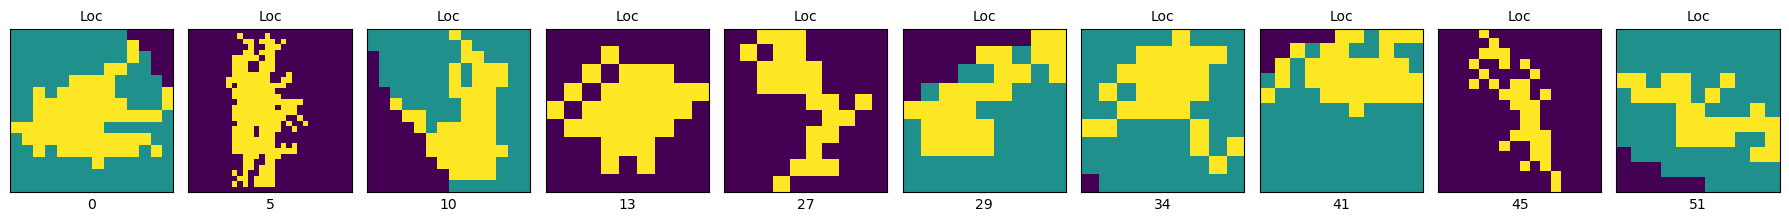

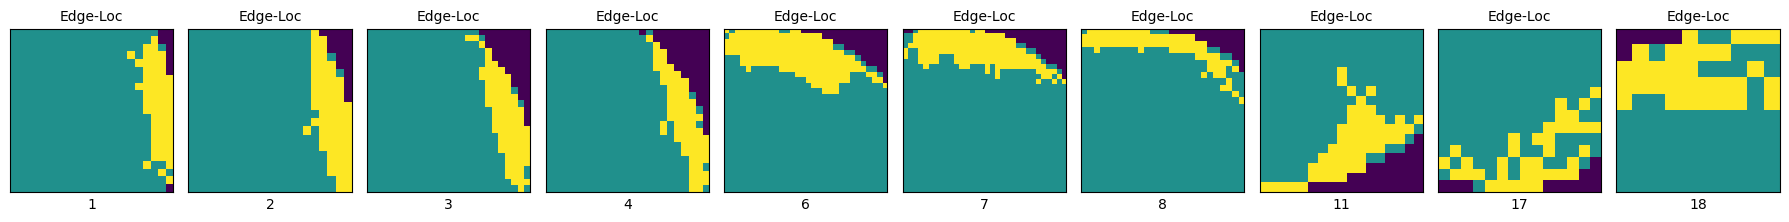

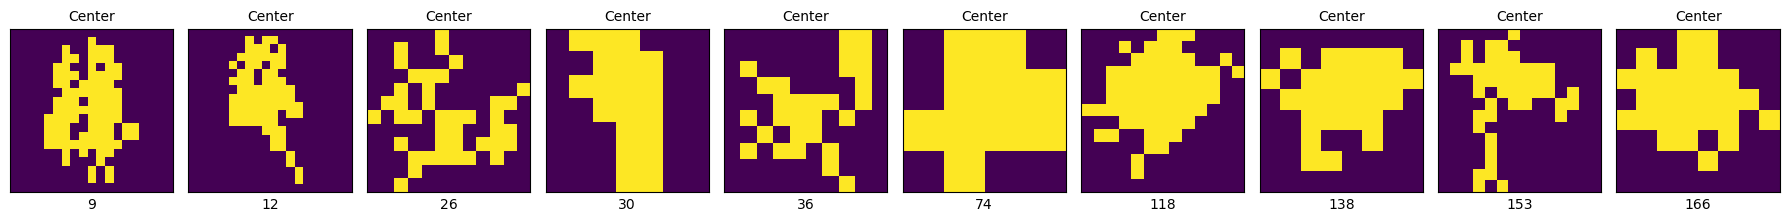

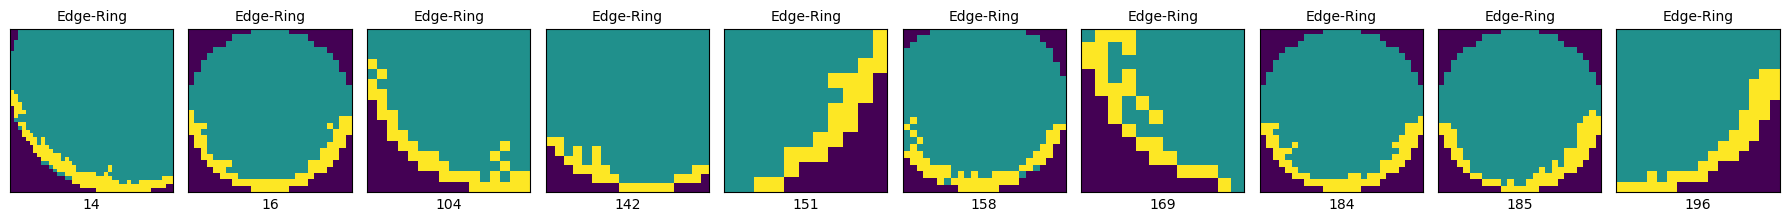

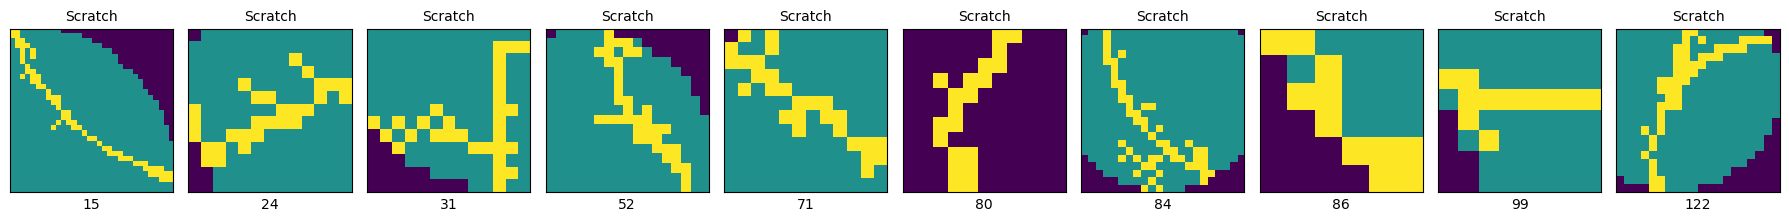

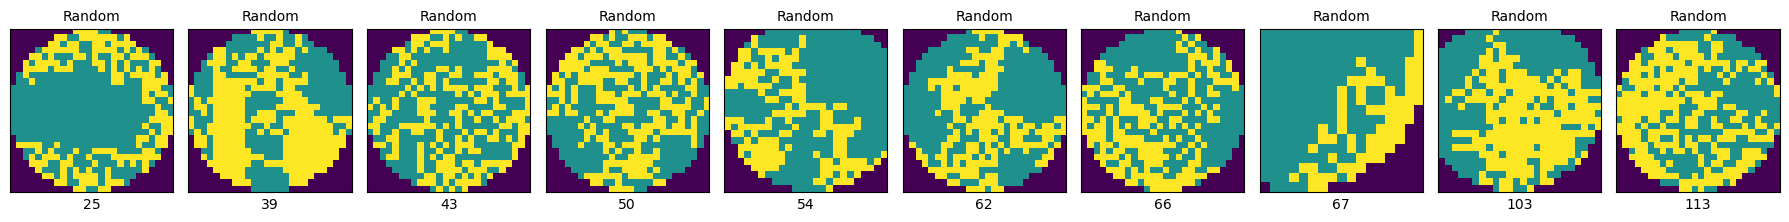

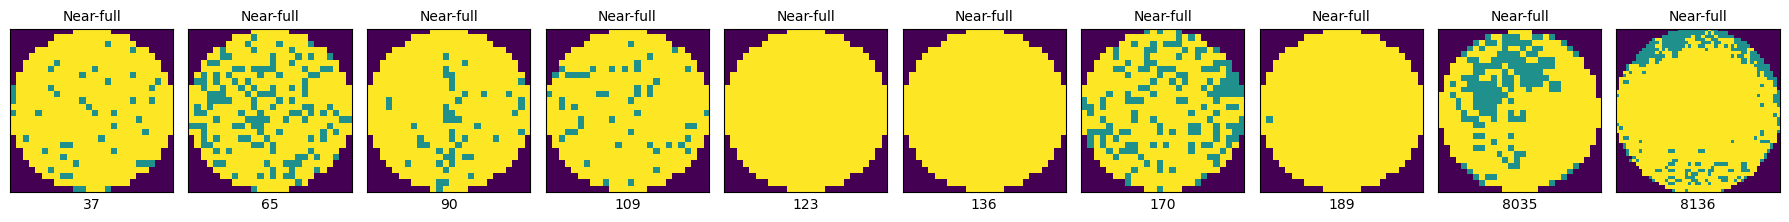

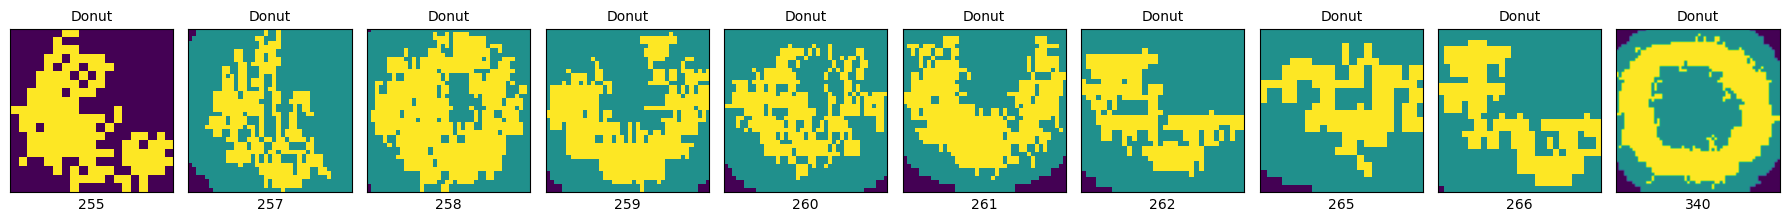

In [6]:
x = [0,1,2,3,4,5,6,7]
labels2 = ['Center','Random','Donut','Edge-Ring','Loc','Scratch','Near-full']

for k in x:
    fig, ax = plt.subplots(nrows = 1, ncols = 10, figsize=(18, 12))
    ax = ax.ravel(order='C')
    for j in [k]:
        img = df.waferMap[df.failureType==labels2[j]]
        for i in range(10):
            ax[i].imshow(take_spot(img[img.index[i]]))
            ax[i].set_title(df.failureType[img.index[i]], fontsize=10)
            ax[i].set_xlabel(df.index[img.index[i]], fontsize=10)
            ax[i].set_xticks([])
            ax[i].set_yticks([])
    plt.tight_layout()
    plt.show() 